In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)    
    def __len__(self):
        return len(self.images)    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])        
        if self.transform:
            img = self.transform(img)       
        return img, label

In [3]:
transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,),(0.5,))])

In [4]:
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.label_emb = nn.Embedding(10, 10)        
        self.model = nn.Sequential(
           nn.Linear(794, 1024),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Dropout(0.3),
           nn.Linear(1024, 512),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Dropout(0.3),
           nn.Linear(512, 256),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Dropout(0.3),
           nn.Linear(256, 1),
           nn.Sigmoid())    
        
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.label_emb = nn.Embedding(10, 10)        
        self.model = nn.Sequential(
           nn.Linear(110, 256),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Linear(256, 512),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Linear(512, 1024),
           nn.LeakyReLU(0.2, inplace=True),
           nn.Linear(1024, 784),
           nn.Tanh())    
        
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [9]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Starting epoch 0...
g_loss: 4.124829292297363, d_loss: 0.14299339056015015


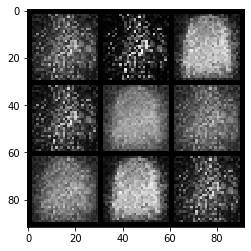

Starting epoch 1...
g_loss: 3.7288787364959717, d_loss: 0.17908909916877747
Starting epoch 2...
g_loss: 4.285362243652344, d_loss: 0.17872440814971924
Starting epoch 3...
g_loss: 3.45159912109375, d_loss: 0.44356441497802734
Starting epoch 4...
g_loss: 3.4305529594421387, d_loss: 0.5282031893730164
Starting epoch 5...
g_loss: 2.415693759918213, d_loss: 0.7738808393478394
Starting epoch 6...
g_loss: 2.2702889442443848, d_loss: 0.779720664024353
Starting epoch 7...
g_loss: 1.739241361618042, d_loss: 0.6767237186431885
Starting epoch 8...
g_loss: 2.056685447692871, d_loss: 1.0428175926208496
Starting epoch 9...
g_loss: 2.6263489723205566, d_loss: 0.9591888189315796
Starting epoch 10...
g_loss: 1.8790581226348877, d_loss: 0.9229106903076172


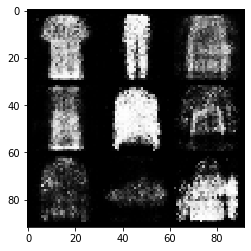

Starting epoch 11...
g_loss: 1.8835372924804688, d_loss: 0.8109931945800781
Starting epoch 12...
g_loss: 1.580723524093628, d_loss: 0.8916875720024109
Starting epoch 13...
g_loss: 1.7378913164138794, d_loss: 1.0079023838043213
Starting epoch 14...
g_loss: 1.775061845779419, d_loss: 0.7150765657424927
Starting epoch 15...
g_loss: 1.5011625289916992, d_loss: 0.99330073595047
Starting epoch 16...
g_loss: 1.380260705947876, d_loss: 0.8326423168182373
Starting epoch 17...
g_loss: 1.833357334136963, d_loss: 1.264044165611267
Starting epoch 18...
g_loss: 1.7639333009719849, d_loss: 1.3953603506088257
Starting epoch 19...
g_loss: 1.6330897808074951, d_loss: 0.9029508233070374
Starting epoch 20...
g_loss: 1.700864315032959, d_loss: 0.8185709714889526


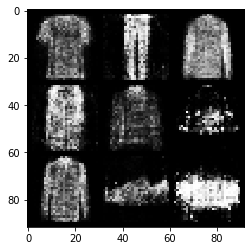

Starting epoch 21...
g_loss: 1.4857693910598755, d_loss: 0.947335958480835
Starting epoch 22...
g_loss: 1.5168445110321045, d_loss: 1.14041006565094
Starting epoch 23...
g_loss: 1.325643539428711, d_loss: 1.01668381690979
Starting epoch 24...
g_loss: 1.3336031436920166, d_loss: 1.0449509620666504
Starting epoch 25...
g_loss: 1.2067840099334717, d_loss: 1.0831605195999146
Starting epoch 26...
g_loss: 1.0780308246612549, d_loss: 1.0147407054901123
Starting epoch 27...
g_loss: 1.165341854095459, d_loss: 0.9773458242416382
Starting epoch 28...
g_loss: 1.2892115116119385, d_loss: 1.005603551864624
Starting epoch 29...
g_loss: 1.096357822418213, d_loss: 1.110022783279419
Starting epoch 30...
g_loss: 1.2115888595581055, d_loss: 1.145172119140625


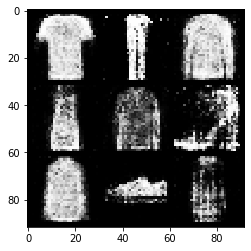

Starting epoch 31...
g_loss: 0.9985846281051636, d_loss: 1.028719425201416
Starting epoch 32...
g_loss: 1.1857643127441406, d_loss: 1.3630279302597046
Starting epoch 33...
g_loss: 1.241943120956421, d_loss: 0.9948086738586426
Starting epoch 34...
g_loss: 1.2487964630126953, d_loss: 1.1072571277618408
Starting epoch 35...
g_loss: 1.1128246784210205, d_loss: 1.177974820137024
Starting epoch 36...
g_loss: 1.1168148517608643, d_loss: 1.093389868736267
Starting epoch 37...
g_loss: 0.6929109692573547, d_loss: 1.1663782596588135
Starting epoch 38...
g_loss: 0.7918834686279297, d_loss: 0.9747897982597351
Starting epoch 39...
g_loss: 0.8495339155197144, d_loss: 1.1543347835540771
Starting epoch 40...
g_loss: 1.0718318223953247, d_loss: 1.347214937210083


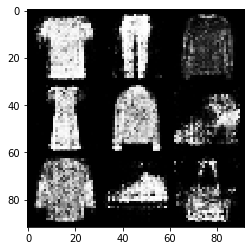

Starting epoch 41...
g_loss: 0.8622612953186035, d_loss: 1.1271917819976807
Starting epoch 42...
g_loss: 1.0425388813018799, d_loss: 1.0980952978134155
Starting epoch 43...
g_loss: 1.074552297592163, d_loss: 1.254150152206421
Starting epoch 44...
g_loss: 1.01100754737854, d_loss: 1.3564496040344238
Starting epoch 45...
g_loss: 0.9376088976860046, d_loss: 1.2788501977920532
Starting epoch 46...
g_loss: 0.961629331111908, d_loss: 1.1766207218170166
Starting epoch 47...
g_loss: 0.913627028465271, d_loss: 1.1127488613128662
Starting epoch 48...
g_loss: 1.019202709197998, d_loss: 1.0957701206207275
Starting epoch 49...
g_loss: 0.8845007419586182, d_loss: 1.0464634895324707
Starting epoch 50...
g_loss: 1.1050405502319336, d_loss: 1.2411012649536133


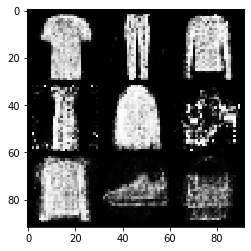

Starting epoch 51...
g_loss: 1.0919842720031738, d_loss: 1.2118773460388184
Starting epoch 52...
g_loss: 0.9463235139846802, d_loss: 1.1229575872421265
Starting epoch 53...
g_loss: 1.0996136665344238, d_loss: 1.153603196144104
Starting epoch 54...
g_loss: 0.7597856521606445, d_loss: 1.1195889711380005
Starting epoch 55...
g_loss: 0.9143829345703125, d_loss: 1.3390188217163086
Starting epoch 56...
g_loss: 1.0852267742156982, d_loss: 1.1771738529205322
Starting epoch 57...
g_loss: 0.9419417381286621, d_loss: 1.3167517185211182
Starting epoch 58...
g_loss: 1.0060611963272095, d_loss: 1.1717588901519775
Starting epoch 59...
g_loss: 0.9389232993125916, d_loss: 1.3063507080078125
Starting epoch 60...
g_loss: 0.8049967288970947, d_loss: 1.2498400211334229


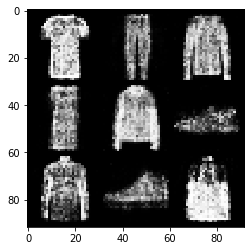

Starting epoch 61...
g_loss: 0.9111307859420776, d_loss: 1.0639071464538574
Starting epoch 62...
g_loss: 0.8851138949394226, d_loss: 1.2646279335021973
Starting epoch 63...
g_loss: 0.8880143761634827, d_loss: 1.3114557266235352
Starting epoch 64...
g_loss: 0.8399345874786377, d_loss: 1.0829612016677856
Starting epoch 65...
g_loss: 0.8811688423156738, d_loss: 1.306077003479004
Starting epoch 66...
g_loss: 0.9977903366088867, d_loss: 1.2048015594482422
Starting epoch 67...
g_loss: 0.8779531121253967, d_loss: 1.0951766967773438
Starting epoch 68...
g_loss: 0.8224970698356628, d_loss: 1.3288912773132324
Starting epoch 69...
g_loss: 0.9248629808425903, d_loss: 1.152258276939392
Starting epoch 70...
g_loss: 0.866714358329773, d_loss: 1.2657947540283203


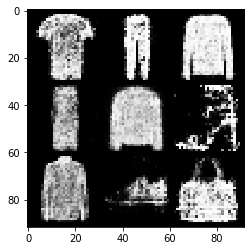

Starting epoch 71...
g_loss: 0.8074865341186523, d_loss: 1.2404024600982666
Starting epoch 72...
g_loss: 0.8140798211097717, d_loss: 1.1391477584838867
Starting epoch 73...
g_loss: 0.8691209554672241, d_loss: 1.3354449272155762
Starting epoch 74...
g_loss: 0.8956483006477356, d_loss: 1.1901127099990845
Starting epoch 75...
g_loss: 0.9384019374847412, d_loss: 1.4080724716186523
Starting epoch 76...
g_loss: 0.8383222818374634, d_loss: 1.2563291788101196
Starting epoch 77...
g_loss: 0.8817397356033325, d_loss: 1.2135064601898193
Starting epoch 78...
g_loss: 0.8208857774734497, d_loss: 1.3269908428192139
Starting epoch 79...
g_loss: 0.9189168214797974, d_loss: 1.3078784942626953
Starting epoch 80...
g_loss: 0.9420957565307617, d_loss: 1.2912274599075317


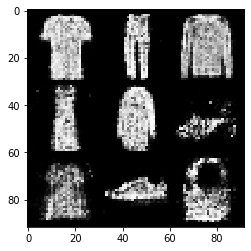

Starting epoch 81...
g_loss: 0.9328213334083557, d_loss: 1.5296661853790283
Starting epoch 82...
g_loss: 0.8409011363983154, d_loss: 1.1640653610229492
Starting epoch 83...
g_loss: 0.816906213760376, d_loss: 1.277000904083252
Starting epoch 84...
g_loss: 0.9620071649551392, d_loss: 1.2224814891815186
Starting epoch 85...
g_loss: 0.8355066776275635, d_loss: 1.405540108680725
Starting epoch 86...
g_loss: 0.7240507006645203, d_loss: 1.3422740697860718
Starting epoch 87...
g_loss: 0.973925769329071, d_loss: 1.2489335536956787
Starting epoch 88...
g_loss: 0.7999368906021118, d_loss: 1.3302592039108276
Starting epoch 89...
g_loss: 0.8859784007072449, d_loss: 1.3549730777740479
Starting epoch 90...
g_loss: 0.8579535484313965, d_loss: 1.284946084022522


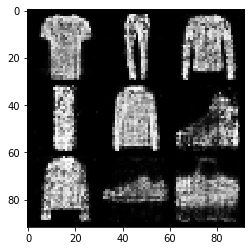

Starting epoch 91...
g_loss: 0.7451192140579224, d_loss: 1.382054328918457
Starting epoch 92...
g_loss: 0.7376917600631714, d_loss: 1.3468409776687622
Starting epoch 93...
g_loss: 0.9336128234863281, d_loss: 1.3587106466293335
Starting epoch 94...
g_loss: 0.8951859474182129, d_loss: 1.213775396347046
Starting epoch 95...
g_loss: 0.9416420459747314, d_loss: 1.3335132598876953
Starting epoch 96...
g_loss: 0.8502649664878845, d_loss: 1.1729919910430908
Starting epoch 97...
g_loss: 0.7866629362106323, d_loss: 1.2884273529052734
Starting epoch 98...
g_loss: 0.8122501373291016, d_loss: 1.39137601852417
Starting epoch 99...
g_loss: 0.8702530860900879, d_loss: 1.3004865646362305


In [11]:
num_epochs = 100
n_critic = 5
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                         generator, d_optimizer, criterion,
                                         real_images, labels)    
        
        
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)    
    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    if (epoch%10) == 0:
        z = Variable(torch.randn(9, 100)).cuda()
        labels = Variable(torch.LongTensor(np.arange(9))).cuda()
        sample_images = generator(z, labels).unsqueeze(1).data.cpu()
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

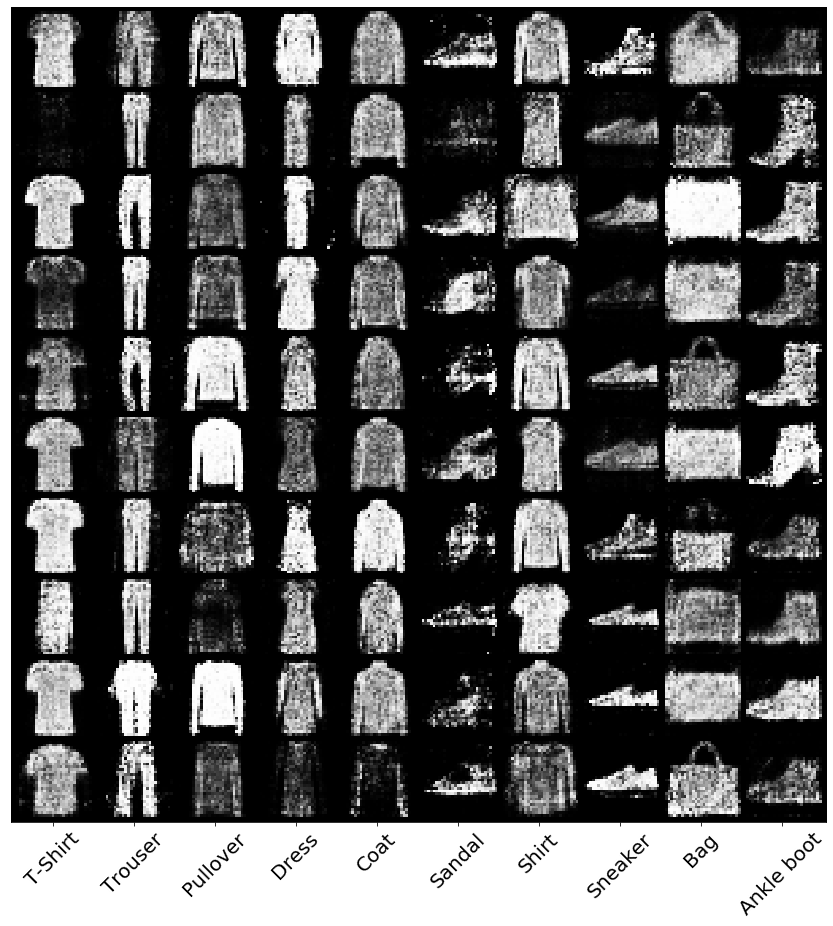

In [12]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)